# 1. Import des bibliothèques

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import os

2025-10-10 06:46:12.981125: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr

In [2]:
pwd

'/tf/code/notebooks/phase_1'

# 2. Définition des chemins et des paramètres

In [3]:
BASE_DIR = '/tf/code/notebooks/phase_1/'
TRAIN_DIR = os.path.join(BASE_DIR, 'multiclass_data')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 5

In [5]:
import os
print("Existe ?", os.path.exists(TRAIN_DIR))
print("Contenu du dossier :", os.listdir(TRAIN_DIR))


Existe ? True
Contenu du dossier : ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


# 3. Préparation des données

In [6]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 5337 images belonging to 5 classes.
Found 1333 images belonging to 5 classes.


# 4. Création du modèle (Transfer Learning)

In [7]:
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')

# Geler les couches du modèle de base
base_model.trainable = False

# Ajouter la nouvelle tête de classification
inputs = Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs, outputs)

model.summary()

W0000 00:00:1759882054.302804    2369 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# 5. Compilation du modèle

In [8]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
from tensorflow.keras.callbacks import TensorBoard
import datetime
import matplotlib.pyplot as plt
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# 6. Entraînement du modèle

In [9]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


2025-10-08 00:08:03.926486: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 154140672 exceeds 10% of free system memory.
2025-10-08 00:08:04.044639: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 156905472 exceeds 10% of free system memory.


  1/167 ━━━━━━━━━━━━━━━━━━━━ 35:29 13s/step - accuracy: 0.1562 - loss: 2.0700

2025-10-08 00:08:06.353568: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 154140672 exceeds 10% of free system memory.
2025-10-08 00:08:06.467669: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 156905472 exceeds 10% of free system memory.


  2/167 ━━━━━━━━━━━━━━━━━━━━ 7:01 3s/step - accuracy: 0.1641 - loss: 1.9340  

2025-10-08 00:08:09.774176: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 154140672 exceeds 10% of free system memory.


167/167 ━━━━━━━━━━━━━━━━━━━━ 560s 3s/step - accuracy: 0.9005 - loss: 0.2676 - val_accuracy: 0.9332 - val_loss: 0.1888
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.9528 - loss: 0.1277 - val_accuracy: 0.9407 - val_loss: 0.1643
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.9524 - loss: 0.1267 - val_accuracy: 0.9370 - val_loss: 0.1639
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.9642 - loss: 0.0997 - val_accuracy: 0.9430 - val_loss: 0.1837
Epoch 5/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.9715 - loss: 0.0808 - val_accuracy: 0.9452 - val_loss: 0.1935


# 7. Sauvegarde du modèle

In [13]:
model.save('multiclass_classifier_model.h5')

Analyse des courbes d'entrainement

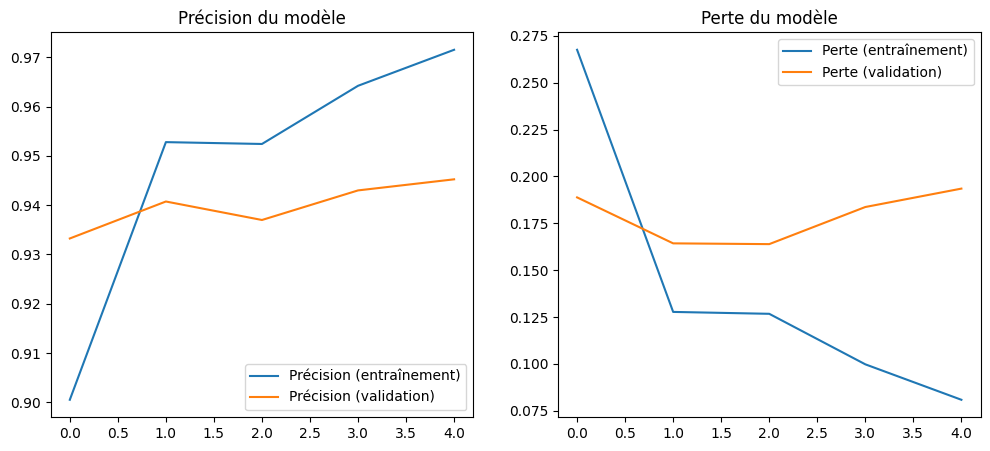

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Précision (entraînement)')
plt.plot(epochs_range, val_acc, label='Précision (validation)')
plt.legend(loc='lower right')
plt.title('Précision du modèle')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perte (entraînement)')
plt.plot(epochs_range, val_loss, label='Perte (validation)')
plt.legend(loc='upper right')
plt.title('Perte du modèle')
plt.show()

In [2]:
# RECOMMANDATION 1 : Implémentation du Fine-Tuning
print("\n--- DÉBUT DU FINE-TUNING ---")


--- DÉBUT DU FINE-TUNING ---


In [3]:
# 2. Définir les chemins et recréer les générateurs de données
# Assurez-vous que ces paramètres sont les MÊMES que lors du premier entraînement

# AJOUT 1: Importer la classe EarlyStopping
# 1. Import des bibliothèques nécessaires
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# AJOUT 1: Importer la classe EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt

BASE_DIR = '/tf/code/notebooks/phase_1/'
TRAIN_DIR = os.path.join(BASE_DIR, 'multiclass_data')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
 # On peut enlever FINE_TUNE_EPOCHS car EarlyStopping gère l'arrêt

# Créez les générateurs de la même manière que pour l'entraînement initial
 
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)
validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 5337 images belonging to 5 classes.
Found 1333 images belonging to 5 classes.


In [4]:
# 3. Charger votre modèle déjà entraîné
print("Chargement du modèle pré-entraîné...")
# Remplacez par le chemin exact de votre modèle .h5
model = load_model('multiclass_classifier_model.h5') 

Chargement du modèle pré-entraîné...


W0000 00:00:1759981563.652243     907 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:

# 4. Préparer le modèle pour le Fine-Tuning 🚀
# On récupère le modèle de base (MobileNetV2) à l'intérieur de notre modèle complet.
# Son nom par défaut est souvent 'mobilenetv2_1.00_224'. Vérifiez avec model.summary() si besoin.
base_model = model.get_layer('mobilenetv2_1.00_224')

# On dégèle le modèle de base
base_model.trainable = True

# On gèle les premières couches et on laisse les couches supérieures entraînables
fine_tune_at = 100 
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [6]:
# 5. Re-compiler le modèle avec un learning rate très bas
print("Re-compilation du modèle pour le fine-tuning...")
model.compile(
    optimizer=Adam(learning_rate=1e-5), # Taux d'apprentissage très faible, c'est crucial !
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary() # Affiche la nouvelle configuration des couches entraînables/non-entraînables


Re-compilation du modèle pour le fine-tuning...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 2,026,053 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [7]:
# 6. Lancer l'entraînement en mode Fine-Tuning
print("Début du fine-tuning...")

# AJOUT 2: Définir le callback EarlyStopping juste avant l'entraînement
early_stopping = EarlyStopping(
    monitor='val_loss',          # Surveiller la perte sur les données de validation
    patience=2,                  # Attendre 2 époques sans amélioration avant d'arrêter
    restore_best_weights=True    # Revenir aux poids du meilleur modèle à la fin
)

# AJOUT 3: Modifier l'appel à model.fit pour inclure le callback
history_fine = model.fit(
    train_generator,
    epochs=10, # On met un nombre d'époques plus grand (ex: 10)
    validation_data=validation_generator,
    callbacks=[early_stopping] # On passe le callback ici dans une liste
)

# 7. Sauvegarder le modèle final, fine-tuné
# ... (votre code reste identique ici)
model.save('multiclass_classifier_model_finetuned.h5')
print("Modèle fine-tuné sauvegardé avec succès !")

Début du fine-tuning...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2025-10-09 03:49:16.906572: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 51380224 exceeds 10% of free system memory.
2025-10-09 03:49:17.283775: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 51380224 exceeds 10% of free system memory.
2025-10-09 03:49:17.869172: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 154140672 exceeds 10% of free system memory.
2025-10-09 03:49:18.921214: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 156905472 exceeds 10% of free system memory.
2025-10-09 03:49:20.135101: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 38535168 exceeds 10% of free system memory.


167/167 ━━━━━━━━━━━━━━━━━━━━ 1268s 7s/step - accuracy: 0.7523 - loss: 0.9605 - val_accuracy: 0.8297 - val_loss: 0.6505
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.9354 - loss: 0.1792 - val_accuracy: 0.8710 - val_loss: 0.4644
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.9445 - loss: 0.1497 - val_accuracy: 0.9100 - val_loss: 0.3003
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.9547 - loss: 0.1281 - val_accuracy: 0.9287 - val_loss: 0.2456
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.9577 - loss: 0.1118 - val_accuracy: 0.9355 - val_loss: 0.2052
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.9636 - loss: 0.1085 - val_accuracy: 0.9490 - val_loss: 0.1701
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 4691s 28s/step - accuracy: 0.9676 - loss: 0.0899 - val_accuracy: 0.9535 - val_loss: 0.1647
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.9640 - loss: 0.0907 - val_accuracy: 0.

Modèle fine-tuné sauvegardé avec succès !


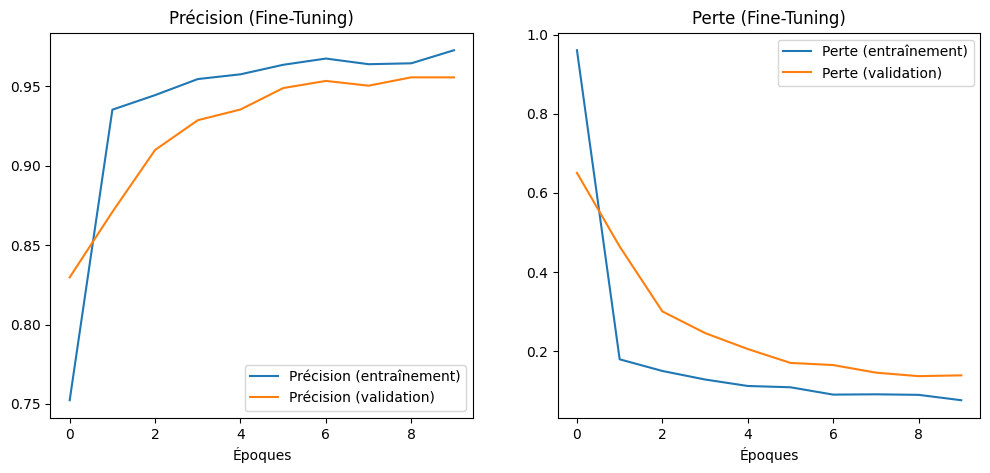

In [8]:
# 8. Visualiser les résultats du fine-tuning
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

# AJOUT 4: Ajuster la plage pour le graphique car le nombre d'époques n'est plus fixe
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Précision (entraînement)')
plt.plot(epochs_range, val_acc, label='Précision (validation)')
plt.legend(loc='lower right')
plt.title('Précision (Fine-Tuning)')
plt.xlabel('Époques')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perte (entraînement)')
plt.plot(epochs_range, val_loss, label='Perte (validation)')
plt.legend(loc='upper right')
plt.title('Perte (Fine-Tuning)')
plt.xlabel('Époques')
plt.show()

